# 01. 데이터 수집

### 1) 정보 찾기

Open API 인증을 요청했지만 아직 승인 받지 못함    

  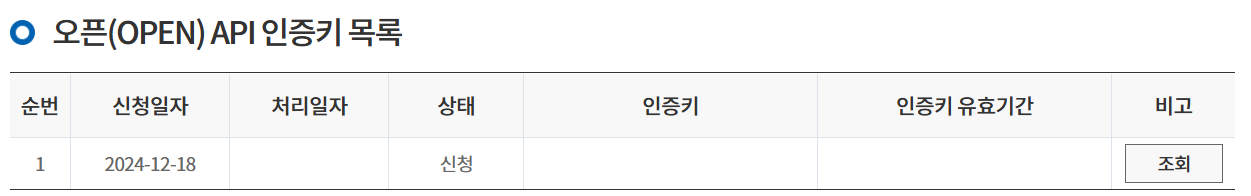

온통청년 (https://www.youthcenter.go.kr/youngPlcyUnif/youngPlcyUnifList.do) 크롤링 하기로 결정

### 2) 크롤링

**라이브러리 불러오기**

In [1]:
import requests
from bs4 import BeautifulSoup as bs
import re
import pickle
import json
import os

**json,pickle 저장 및 불러오기 함수 정의**

In [2]:
def save_pickle(path: str, file_name: str, data: list):
    """
    데이터를 pickle 파일로 저장.
    """
    os.makedirs(path, exist_ok=True)
    with open(f"{path}/{file_name}", "wb") as f:
        pickle.dump(data, f)

def load_pickle(path: str) -> list:
    """
    pickle 파일에서 데이터 불러오기.
    """
    with open(path, "rb") as f:
        return pickle.load(f)

def save_json(path: str, file_name: str, data: list):
    """
    데이터를 json 파일로 저장.
    """
    os.makedirs(path, exist_ok=True)
    with open(f"{path}/{file_name}", "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4, ensure_ascii=False)

def load_json(path: str) -> list:
    """
    json 파일에서 데이터 불러오기.
    """
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)


**정책 ID 크롤링**
- 목록 정렬: 1 페이지 - 60개 정책, 총 59 페이지.
- 정책 모집 현황은 '진행중','상시','신청 마감'으로 3가지. `24년 12월 23일 기준`으로 `상시`, `진행중`인 정책들만 추출.
   ```
    <div class="badge">
      <span class="label green">진행중</span>
      <span class="cate">주거분야</span>
    </div>
    ```
- 각 정책의 링크가 아래와 같이 구성. id 부분에서 `dtlLink_`를 제외한 부분이 각 정책의 코드번호.
  ```
   <a href="#"id="dtlLink_R2024011018628"onclick="f_Detail('R2024011018628');"class="tit">청년 주택드림 청약통장</a>
   ```
- 1 페이지부터 59 페이지까지 각 페이지에 있는 정책들의 id만 list로 추출.


In [3]:
def get_ids_with_state(page_num: int, url: str) -> list:
    """
    청년 정책의 ID 수집.
    Parameters:
        page_num (int): 추출하려는 총 페이지 수
        url (str): 추출 대상의 페이지 링크를 조합할 베이스 링크
    Returns:
        policy_id_list (list): 상시, 진행중인 정책의 ID를 list로 모아 반환합니다.
    """
    policy_id_list = []
    for i in range(1, page_num + 1):
        response = requests.get(f"{url}{i}")
        soup = bs(response.text, "lxml")
        
        badges = soup.select("div.badge")
        titles = soup.select("a.tit")
        organ = soup.select("div.organ-name")
        
        for j in range(len(titles)):
            badge = badges[j].find("span", attrs={"label"}).text
            if badge in ["진행중", "상시"]:
                policy_id = titles[j].attrs["id"].replace("dtlLink_", "")
                organ_name = re.sub(r"<.*?>", "", str(organ[j].select_one("p")))
                organ_name = "세종" if organ_name == "세종 세종" else organ_name
                if policy_id not in policy_id_list:
                    policy_id_list.append([policy_id, organ_name])
    
    return policy_id_list


**정책 상세 정보 크롤링**
- index

| index | name               | index | name                     |
| ----- | ------------------ | ----- | ------------------------ |
| 0     | "정책 번호"        | 13    | "추가 단서 사항"         |
| 1     | "정책 분야"        | 14    | "참여 제한 대상"         |
| 2     | "지원 내용"        | 15    | "신청 절차"              |
| 3     | "사업 운영 기간"   | 16    | "심사 및 발표"           |
| 4     | "사업 신청청 기간" | 17    | "신청 사이트"            |
| 5     | "지원 규모(명)"    | 18    | "제출 서류"              |
| 6     | "비고"             | 19    | "기타 유익 정보"         |
| 7     | "연령"             | 20    | "주관 기관"              |
| 8     | "거주지 및 소득"   | 21    | "운영 기관"              |
| 9     | "학력"             | 22    | "사업관련 참고 사이트 1" |
| 10    | "전공"             | 23    | "사업관련 참고 사이트 2" |
| 11    | "취업 상태"        | 24    | "첨부파일"               |
| 12    | "특화 분야"        |


**HTML 문자열 처리 함수 정의**
- '객체.text'로 추출되지 않는 요소들이 존재. -> '객체.contents'로 개별 요소 추출.
- 요소에 `<br/>`이 있는 경우 이 현상이 잘 나타남. -> `<br/>`태그 제거
- '객체.text'로 추출한 경우 과도한 공백 및 줄바꿈 발견
- '객체.contents'로 추출할 경우 과도한 공백 및 줄바꿈을 이스케이프 문자로 추출 -> `\n, \t`등 이스케이프 문자 제거
- 여기서 과도한 공백이란 두 칸 이상의 띄어쓰기를 한 경우. 전체 띄어쓰기를 한 칸으로 맞추려면 시간이 오래 소요되기 때문에 두 칸만 제거.

In [4]:
def formated(string: str) -> str:
    """
    HTML 태그, 이스케이프 문자, 과도한 공백 제거.
    """
    tag_format = r"<.*?>"
    string = string.replace("\n", "").replace("\t", "")
    string = re.sub(tag_format, "", str(string))
    string = string.replace("  ", "")
    return string

In [5]:
def crawling(policy_id_list: list, url: str, params: dict, cont_attrs: bool = True) -> list:
    """
    정책 상세 정보를 수집.
    """
    total_policy = []
    format = {"br": r"<br/>", "a": r"<a href"}
    
    for id, organ in policy_id_list:
        policy = {}
        try:
            response = requests.get(f"{url}{id}")
        except:
            response = requests.get(f"{url.replace('https', 'http')}{id}")
        
        soup = bs(response.text, "html.parser")

        # 정책 이름 추출
        title = soup.find(params["title"][0], params["title"][1]).text
        policy["정책 이름"] = title
        
        if cont_attrs:
            policy["기관"] = organ
            subtitle = soup.find("p", "doc_desc").text
            subtitle = subtitle.replace("\r", " ")
            subtitle = subtitle.strip()
            policy["요약"] = subtitle
            list_tit = soup.find_all(
                name=params["list_tit"][0], attrs=params["list_tit"][1]
            )
            list_cont = soup.find_all(
                name=params["list_cont"][0], attrs=params["list_cont"][1]
            )
        else:
            list_tit = soup.find_all(name=params["list_tit"][0])
            list_cont = soup.find_all(name=params["list_cont"][0])
        
        # 항목 내용 처리
        for i in range(len(list_tit)):
            # list_cont[i].contents = ["\n", "ㅁㅁㅁ", "\n"] 또는 ["\n\t\t\t\tㅁㅁㅁㅁ\n\t\t\t\t", "<br/>", "ㅁㅁㅁ"]과 같이 나옴
            if len(list_cont[i].contents) > 1:
                contents = []
                for j in range(len(list_cont[i].contents)):
                    content = list_cont[i].contents[j]
                    # <br/> 제거
                    if re.match(format["br"], str(content)) != None:
                        content = None
                    # url만 있는 경우 추출
                    elif re.match(format["a"], str(content)) != None:
                        content = content.attrs["href"]
                    # 그 외 공백 제거, '\n', '\t', 제거 안된 html 태그 제거
                    else:
                        content = content.text
                        content = content.strip()
                        content = formated(content)
                    # 처리 작업이 끝난 후 의미있는 요소만 contents(list)에 추가
                    if content not in [None, "\n", "", ","]:
                        # \r이 있을 경우 이를 구분자로 분할한 뒤 삽입
                        if "\r" in content:
                            content = content.split("\r")
                            for con in content:
                                contents.append(con)
                        else:
                            contents.append(content)
                if len(contents) == 1:
                    contents = "".join(contents)
            else:
                contents = list_cont[i].contents
                contents = "".join(contents)
                contents = formated(contents)

            # 동일한 요소가 contents(list)에 들어있을 경우
            if (
                isinstance(contents, list)
                and len(contents) == 2
                and contents[0] == contents[1]
            ):
                contents = set(contents)
                contents = "".join(contents)
                contents = formated(contents)
            # 정책의 항목 이름, 내용 연결
            policy[list_tit[i].text] = contents
        total_policy.append(policy)
    return total_policy

**main 코드**
- 해당 웹 사이트 크롤링

In [ ]:
# 저장 경로 생성
DATA_DIR = "../data"
os.makedirs(DATA_DIR, exist_ok=True)

# 정책 ID 수집
URL = "https://www.youthcenter.go.kr/youngPlcyUnif/youngPlcyUnifList.do?pageUnit=60&pageIndex="
policy_id_list = get_ids_with_state(59, URL)
print(f"{len(policy_id_list)}개 정책 ID 크롤링 완료")

# 저장
save_pickle(f"{DATA_DIR}", "policy_id_list.pkl", policy_id_list)
print("policy_id_list 저장 완료")

# 정책 상세 정보 크롤링
DETAIL_URL = "https://www.youthcenter.go.kr/youngPlcyUnif/youngPlcyUnifDtl.do?bizId="
params = {
    "title": ["h2", "doc_tit01 type2"],
    "list_tit": ["div", "list_tit"],
    "list_cont": ["div", "list_cont"],
}
total_policy = crawling(policy_id_list, DETAIL_URL, params, cont_attrs=True)
print(f"{len(total_policy)}개 정책 상세 정보 크롤링 완료")

# 저장
save_json(f"{DATA_DIR}", "policy.json", total_policy)
print("policy.json 저장 완료")


1337개 정책 ID 크롤링 완료
policy_id_list 저장 완료


# 02. 데이터 전처리

### 1) 데이터 구조화

**사용되지 않을 항목 삭제**
- key값이 아래에 해당하면 항목 삭제
  >["정책 번호", "신청 사이트", "사업관련 참고 사이트 1", "사업관련 참고 사이트 2", "첨부파일"]


**의미 없는 값 삭제**
- value값이 아래에 해당하면 항목 삭제
  >["제한없음", "", "-", "상관없음", "□제한없음","□ 제한없음","- 제한없음","-제한없음"]

In [6]:
# 삭제 항목 정의
remove_keys = [
    "정책 번호", "신청 사이트", 
    "사업관련 참고 사이트 1", "사업관련 참고 사이트 2", "첨부파일"
]

remove_values = [
    "제한없음", "", "-", "상관없음", "□제한없음",
    "□ 제한없음","- 제한없음","-제한없음"
]

# 삭제 함수 정의
def remove_keys_from_data(data, keys):
    if isinstance(data, list):
        return [remove_keys_from_data(item, keys) for item in data]
    elif isinstance(data, dict):
        return {
            key: remove_keys_from_data(value, keys)
            for key, value in data.items()
            if key not in keys
        }
    else:
        return data

def remove_values_from_data(data):
    if isinstance(data, list):
        return [remove_values_from_data(item) for item in data if item not in remove_values]
    elif isinstance(data, dict):
        return {
            key: remove_values_from_data(value)
            for key, value in data.items()
            if value not in remove_values
        }
    else:
        return data
    
# 불러오기 
data = load_json("../data/policy.json")

# 삭제
data_cleaned_keys = remove_keys_from_data(data, remove_keys)
preprocess_data = remove_values_from_data(data_cleaned_keys)

# 저장
save_json("../data","policy_result.json", preprocess_data)

print("policy_result.json 저장 완료")

policy_result.json 저장 완료


### 2) 텍스트 전처리

**불용어 삭제**
- 문서에서 `100번 이상` 등장한 단어를 frequent_words 리스트에 저장
- 리스트에서 불용어로 판단 되는 것들 추출
- 성능 평가 후 성능 최적화를 위해 삭제하는 단어를 변경할 수 있음
- 불용어 리스트
  > "수행", "경우", "해당", "통하여", "대한", "관련","등", "및", "또는", "중인", "통해",
    "따라", "서비스", "제공", "프로그램", "참여", "따른", "대한", "해당", "관한","이용", 
    "등을", "두고"


In [7]:
import json
import re
from collections import Counter

# 불러오기
data = load_json("../data/policy.json")

# 모든 텍스트 추출
def text_from_json(data):
    """
    JSON 데이터에서 모든 문자열을 추출.
    """
    texts = []
    if isinstance(data, dict):
        for value in data.values():
            texts.extend(text_from_json(value))
    elif isinstance(data, list):
        for item in data:
            texts.extend(text_from_json(item))
    elif isinstance(data, str):
        texts.append(data)
    return texts

# 단어 분리
def text_to_word(text):
    """
    텍스트를 정제하고 단어 단위로 분리.
    """
    text = re.sub(r'[^가-힣a-zA-Z0-9\s]', '', text)  # 특수문자 제거
    words = text.split()  # 공백 기준으로 단어 분리
    return words

# 자주 등장하는 단어 찾기
def get_frequent_words(words, threshold=100):
    """
    단어 목록에서 자주 등장하는 단어를 찾음.
    """
    word_counts = Counter(words)
    frequent_words = [word for word, count in word_counts.items() if count >= threshold]
    return frequent_words

# 실행
if __name__ == "__main__":

    # 불러오기
    FILE_PATH = "../data/policy_result.json"
    data = load_json(FILE_PATH)
    
    # 텍스트 추출
    texts = text_from_json(data)
    
    # 단어 분리
    all_words = []
    for text in texts:
        all_words.extend(text_to_word(text))
    
    # 50번 이상 등장하는 단어
    threshold = 100
    frequent_words = get_frequent_words(all_words, threshold)
    
    # 출력
    print("[100번 이상 등장하는 단어]")
    for i in range(0, len(frequent_words), 10):
        print(", ".join(frequent_words[i:i + 10]))


[100번 이상 등장하는 단어]
청년, 청년의, 내, 위해, 지원, 주거분야, 최대, 연, 있는, 자
기준, 월, 경우, 연계, 1년, 이상, 가입, 시, 이하, 주택
출산, 2024년, 12월31일, 가능, 만, 19세, 34세, 소득, 대상, 월세
매월, 2024, 2, 신청, 무주택, 중위소득, 등, 및, 확인, 제외
포함, 거주, 별도, 또는, 중인, 후, 온라인, 방문, 지급, 신청서
서류, 사본, 사업, 심사, 통해, 고용노동부, 위한, 일자리분야, 1, 따라
서비스, 제공, 기간, 프로그램, 참여, 취업, 따른, 단, 1회, 추가
상시, 중, 수, 6개월, 이내, 필요한, 1인, 가구, 문의, 대상자
동의서, 제출, 신청인이, 관련, 증빙서류, 3, 4, 5, 3개월, 보건복지부
지역, 복지문화분야, 맞춤형, 부담, 참고, 대한, 모두, 해당, 배우자, 현재
관한, 홈페이지, 관할, 선정, 기타, 주민등록상, 동일, 중소기업, 이용, 불가
그, 신분증, 주민등록등본, 창업, 지원내용, 대상으로, 필수, 등을, 1인당, 미만
각, 개별, 지원사업, 18세, 이후, 39세, 공고문, 20241231, 본인, 주소지
거주지, 읍면동, 행정복지센터, 예산, 미취업, 안내, 참조, 무료, 발급, 기업
모집, 서울, 운영, 교육, 서울시, 신혼부부, 신청자, 작성, 접수, 내용
주관기관과, 12, 도내, 상담, 자립준비청년, 신청일, 두고, 신청방법, 지원대상, 거주하는
임차인, 교육분야, 30만원, 사업장, 사업자, 소상공인, 청년들의, 통한, 지원금, 면접
소재, 사업기간, 참여자, 일자리, 11, 대학생, 미정, 경기, 경기도, 공고
관내, 이메일, 경북, 경남, 컨설팅, 1부, 북구, 동구, 남구, 울산광역시
전세보증금반환보증, 보증료, 울산


**url 삭제**
- 정규표현식이 'http://'(http,https),'.kr'인 경우 url이라고 판단하고 삭제  

**특수기호 삭제**
- 숫자, 한글, 영어를 제외하고 삭제
- 소수점 유지를 위해 '.'은 유지

In [8]:
import re

# 불러오기
data = load_json("../data/policy_result.json")

# 불용어 
stopwords = [
    "수행", "경우", "해당", "통하여", "대한", "관련","등", "및", "또는", "중인", "통해",
    "따라", "서비스", "제공", "프로그램", "참여", "따른", "대한", "해당", "관한","이용", 
    "등을", "두고"
]

# 제거 함수
def remove_text(text):
    if isinstance(text, str):
        # URL 제거
        text = re.sub(r'\bhttps?://[^\s]*\.kr\b', '', text)
        
        # 특수기호 제거 (숫자, 한글, 영어 유지)
        text = re.sub(r'[^가-힣a-zA-Z0-9\s.~%]',' ', text)
        
        # 불용어 제거
        for stopword in stopwords:
            text = text.replace(stopword, '')
        return text   
    
    return text

# 데이터 처리
def process_json(data):
    if isinstance(data, dict):
        return {key: process_json(value) for key, value in data.items()}
    elif isinstance(data, list):
        return [process_json(item) for item in data]
    elif isinstance(data, str):
        return remove_text(data)
    else:
        return data


cleaned_data = process_json(data)

# 저장
save_json("../data","policy_result.json",cleaned_data)
print("policy_result.json 저장 완료")

policy_result.json 저장 완료


### 3) 토큰화

**key- value값 병합**
- key 값:'정책 이름', '기관', '요약', '정책 분야'인 경우는 유지
- 나머지 모든 key,value값 문자열로 반환 -> 병합 후 key 값:"내용"의 value값에 저장

**토큰화**
- 청년 정책 챗봇은 정확한 정보 전달을 최우선으로 여김
- chunk size를 지정해 토큰화하지 않고 key-value값 병합된 문자열을 하나의 토큰으로 나눔

In [9]:
import json
import re

# 불러오기
data = load_json("../data/policy_result.json")

# 문자열 병합 
def merge_values(item):
    """
    리스트, 딕셔너리, 문자열을 하나의 문자열로 병합
    """
    if isinstance(item, list):
        return " ".join(merge_values(sub_item) for sub_item in item)
    elif isinstance(item, dict):
        return " ".join(f"{key}: {merge_values(value)}" for key, value in item.items())
    elif isinstance(item, str):
        return item.strip()
    else:
        return str(item)


# 특정 키는 유지, 나머지는 병합
def restructure_policy_data(data):
    """
    '정책 이름', '기관', '요약', '정책 분야'는 유지하고 나머지는 '내용'에 병합
    """
    result = []
    if isinstance(data, list):
        for item in data:
            if isinstance(item, dict):
                policy = {
                    "정책 이름": item.get("정책 이름", "알 수 없음"),
                    "기관": item.get("기관", "알 수 없음"),
                    "요약": item.get("요약", "알 수 없음"),
                    "정책 분야": item.get("정책 분야", "알 수 없음")
                }

                # '내용'에 나머지 항목 병합
                remaining_content = [
                    f"{key}: {merge_values(value)}"
                    for key, value in item.items()
                    if key not in ["정책 이름", "기관", "요약", "정책 분야"]
                ]
                policy["내용"] = " ".join(remaining_content)

                result.append(policy)
    return result


# 실행행
restructured_data = restructure_policy_data(data)


# 저장
save_json("../data", "policy_result.json", restructured_data)
print("policy_result.json 저장 완료")



policy_result.json 저장 완료


### 4) 추가 수정
성능 평가 후 개선되면 좋겠다고 판단하여 추가적으로 처리

**기관->지역**
- 기관에 지역명이 포함되어 있어 지역 구분 용으로 사용 ex) "기관": "인천 계양구"
- 지역을 잘 구분하지 못하고 답을 보내 더 명확하게 구분하고자 다음과 같이 변경
>   r'경.*북.*': '경상북도',   
    r'경.*남.*': '경상남도',   
    r'강.*원.*': '강원도',   
    r'전.*북.*': '전라북도',   
    r'전.*남.*': '전라남도',   
    r'충.*북.*': '충청북도',   
    r'충.*남.*': '충청남도',   
    r'제.*주.*': '제주특별자치도',   
    r'서.*울.*': '서울특별시',   
    r'부.*산.*': '부산광역시',   
    r'대.*구.*': '대구광역시',   
    r'대.*전.*': '대전광역시',   
    r'광.*주.*': '광주광역시',   
    r'울.*산.*': '울산광역시',   
    r'인.*천.*': '인천광역시',   
    r'세.*종.*': '세종특별자치시'   

- 지역명이 없는 기관은 전국 대상으로 처리 ex) "기관": "고용노동부"

In [10]:
import json
import re

# 불러오기
data = load_json("../data/policy_result.json")

# 지역 매핑 (정규표현식: 기관명에 포함된 지역명)
region_patterns = {
    r'경.*북.*': '경상북도',
    r'경.*남.*': '경상남도',
    r'강.*원.*': '강원도',
    r'전.*북.*': '전라북도',
    r'전.*남.*': '전라남도',
    r'충.*북.*': '충청북도',
    r'충.*남.*': '충청남도',
    r'제.*주.*': '제주특별자치도',
    r'서.*울.*': '서울특별시',
    r'부.*산.*': '부산광역시',
    r'대.*구.*': '대구광역시',
    r'대.*전.*': '대전광역시',
    r'광.*주.*': '광주광역시',
    r'울.*산.*': '울산광역시',
    r'인.*천.*': '인천광역시',
    r'세.*종.*': '세종특별자치시'
}

# 데이터 변환
def replace_institution_with_region(data):
    """
    '기관'을 '지역'으로 키를 대체하고 순서를 유지합니다.
    """
    for policy in data:
        if "기관" in policy:
            institution = policy["기관"]
            region = '전국'  # 기본값 설정
            
            # 기관명에서 지역 매칭
            for pattern, mapped_region in region_patterns.items():
                if re.search(pattern, institution):
                    region = mapped_region
                    break
            
            # '기관'을 '지역'으로 대체 (순서 유지)
            updated_policy = {}
            for key, value in policy.items():
                if key == "기관":
                    updated_policy["지역"] = region
                else:
                    updated_policy[key] = value
            
            # 기존 항목을 새로운 항목으로 교체
            policy.clear()
            policy.update(updated_policy)

# 실행행
replace_institution_with_region(data)

# 저장
save_json("../data", "policy_result.json", data)
print("policy_result.json 저장 완료")


policy_result.json 저장 완료


**key값 띄어쓰기 삭제**
- key값의 띄어쓰기 때문에 인식에 헷갈림이 있어 보임
- '운영 기관'보다 '운영기관'을 더 잘 인식   

**'분야' 삭제**
- key 값 '정책 분야'의 내용에 담긴 마지막 두 글자 '분야' 삭제 
    - ex) 일자리분야 -> 일자리
- 더 다양한 질문에서 잘 인식
    - ex) 일자리에 고민이 있어.

In [11]:
# 불러오기
data = load_json("../data/policy_result.json")

# 띄어쓰기 제거 
def remove_spaces(data):
    """
    모든 Key에서 띄어쓰기를 제거합니다.
    """
    if isinstance(data, list):
        return [remove_spaces(item) for item in data]
    elif isinstance(data, dict):
        return {key.replace(" ", ""): remove_spaces(value) for key, value in data.items()}
    else:
        return data

# 마지막 2글자 삭제 
def modify_policy_field(data):
    """
    "정책분야"의 Value 마지막 2글자를 삭제합니다.
    """
    if isinstance(data, list):
        for item in data:
            modify_policy_field(item)
    elif isinstance(data, dict):
        if "정책분야" in data and isinstance(data["정책분야"], str):
            data["정책분야"] = data["정책분야"][:-2]  # 마지막 2글자 제거
        for key, value in data.items():
            modify_policy_field(value)

# 실행
data = remove_spaces(data)
modify_policy_field(data)

# 저장
save_json("../data", "policy_result.json", data)
print("policy_result.json 저장 완료")


policy_result.json 저장 완료


# 03. RAG 시스템

RAG(Retrieval-Augmented Generation) 모델을 사용하여 정보를 제공하는 시스템 구현함.
문서 검색을 위한 vector store와 context 기반 응답 생성을 위한 언어 모델을 통합하였음.

### 1) 환경 설정


**.env 파일**

- API키 저장한 .env 파일 불러오기


In [1]:
from dotenv import load_dotenv

load_dotenv()

True

**라이브러리 불러오기**


In [16]:
import os
from module.file import load_json
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.schema import Document
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.memory import ConversationBufferMemory
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain_openai import ChatOpenAI
from langchain_community.tools import TavilySearchResults
from langchain_core.tools import tool
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables.history import RunnableWithMessageHistory, RunnableLambda
from langchain.schema import HumanMessage
from operator import itemgetter
from textwrap import dedent
from itertools import chain

**디렉토리 설정**
1) 경로 설정
   - text-embedding-ada-002: 고품질 임베딩을 생성하기 위해 해당 임베딩 모델을 선택함.

2) JSON 데이터 불러오기
   - 개별 정책 text를 통합하여 metadata와 함께 JSON 문서를 생성하였음.

In [3]:
# 경로 설정
DIRECTORY_PATH = r"..\data"
PERSIST_DIRECTORY = r"..\data\vector_store\policy"
COLLECTION_NAME = "policy"
EMBEDDING_MODEL_NAME = "text-embedding-ada-002"
TOKENIZED_DATA_PATH = os.path.join(DIRECTORY_PATH, "policy_result.json")


# JSON 데이터 불러오기
data = load_json("../data/policy_result.json")

# Document 객체로 변환
documents = []
for policy_name, contents in data.items():
    merged_text = " ".join(contents)
    documents.append(
        Document(
            page_content=merged_text,
            metadata={"name": policy_name, "source": TOKENIZED_DATA_PATH},
        )
    )

# 임베딩 모델 초기화
embedding_model = OpenAIEmbeddings(model=EMBEDDING_MODEL_NAME)

# Vector Store 생성/로드
if os.path.exists(PERSIST_DIRECTORY):
    print(f"기존 Vector Store를 {PERSIST_DIRECTORY}에서 로드합니다.")
    vector_store = Chroma(
        persist_directory=PERSIST_DIRECTORY,
        collection_name=COLLECTION_NAME,
        embedding_function=embedding_model,
    )
else:
    print(f"새로운 Vector Store를 {PERSIST_DIRECTORY}에 생성합니다.")
    os.makedirs(PERSIST_DIRECTORY, exist_ok=True)
    vector_store = Chroma.from_documents(
        documents=documents,
        embedding=embedding_model,
        collection_name=COLLECTION_NAME,
        persist_directory=PERSIST_DIRECTORY,
    )

# Vector Store 저장
vector_store.persist()
print(f"Vector Store 저장 완료")

# 저장된 파일 확인
saved_files = os.listdir(PERSIST_DIRECTORY)
print(f"저장된 파일 목록: {saved_files}")

C:\Users\Playdata\AppData\Local\Temp\ipykernel_20200\4180259025.py:24: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding_model = OpenAIEmbeddings(model=EMBEDDING_MODEL_NAME)


기존 Vector Store를 ..\data\vector_store\policy에서 로드합니다.


C:\Users\Playdata\AppData\Local\Temp\ipykernel_20200\4180259025.py:29: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_store = Chroma(


Vector Store 저장 완료
저장된 파일 목록: ['86e20239-3a1e-453c-a1d0-3920361726f6', 'chroma.sqlite3']


C:\Users\Playdata\AppData\Local\Temp\ipykernel_20200\4180259025.py:45: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vector_store.persist()


In [4]:
# Vector Store 데이터 확인
try:
    results = vector_store.similarity_search("청년 주택드림 청약통장")
    print("검색 결과 예시:")
    print(results[0] if results else "검색 결과 없음")
except Exception as e:
    print(f"검색 오류: {e}")

검색 결과 예시:
page_content='기관:경남 정책 분야:주거분야 지원 내용:  자립준비청년의 주거 복지를 위한 주택청약종합저축 납입지원금 지원   우리은행 주택청약종합저축  청년우대형 주택청약종합저축  별도자격요건 필요  통장 개설    매월 주택청약종합저축 계좌로 2만원 자동이체   지원예산  1인당 월 2만원씩 24개월 지원  본인 자금으로 1회 납입 후 2회~25회차까지 납입금 지원    신청기간은 모집 마감시까지 사업 신청 기간:상시 비고:2024.01.16.~2024.01.24. 연령:만 19세 ~ 34세 거주지 및 소득:퇴소했거나 재원중이거나 보호가 종료된 아동 만18세~34세  1 000명 신청 절차:온라인 홈페이지 바로가기  신청 주관 기관:적십자사 운영 기관:주관기관과 동일' metadata={'name': '유스타트 주택청약 종합저축 지원사업', 'source': '..\\data\\policy_result.json'}


**Retriever 설정**
- MMR(Maximal Marginal Relevance) 방식을 사용하여 <br> 검색 결과의 다양성과 관련성을 균형있게 검색하도록 함.
- 복수의 답변을 생성하게 될 경우를 위해 k 값을 10으로 설정함.

In [5]:
# Retriever 설정 - 검색 설정
retriever = vector_store.as_retriever(
    search_type="mmr",
    search_kwargs={
        "k": 5,
        "fetch_k": 10,
        "lambda_mult": 0.2,
    },
)

print(f"vector store가 {PERSIST_DIRECTORY}에서 성공적으로 생성/로드되었습니다.")

vector store가 ..\data\vector_store\policy에서 성공적으로 생성/로드되었습니다.


**DB 기반 검색 도구, Web 기반 검색 도구 생성**
- 데이터에 빠르게 접근하고, 최신 외부 정보를 검색할 수 있도록 tool을 생성함.

In [6]:
# db 검색 tool
@tool
def search_policy(query: str) -> list[Document]:
    """
    Vector Store에 저장된 청년 지원 정책과 해당 정책의 정보를 검색한다.
    이 도구는 청년 지원 정책 관련 질문에 대해 실행한다.
    """
    result = retriever.invoke(query)
    return result if result else [Document(page_content="검색 결과가 없습니다.")]


# web 검색 tool
@tool
def search_web(query: str) -> list[Document]:
    """
    Web에서 청년 지원 정책과 해당 정책의 정보를 검색한다.
    이 도구는 청년 지원 정책 관련 질문에 대해 실행한다.
    """
    try:
        tavily_search = TavilySearchResults(max_results=2)
        result = tavily_search.invoke(query)
        if result:
            return [
                Document(
                    page_content=item.get("content", ""),
                    metadata={"title": item.get("title", "")},
                )
                for item in result
            ]
        else:
            return [Document(page_content="검색 결과가 없습니다.")]
    except Exception as e:
        return [Document(page_content=f"오류 발생: {str(e)}")]

**Prompt 설정**
- 사용자의 질문에 필요한 답변을 넘어 불필요한 정보까지 제공하는 경우가 있었으므로 <br> 3번 항목을 가이드라인에 포함하였음.
- 정보가 없는 지역과 관련된 질문 등 해당 RAG가 답변하지 못하는 영역의 질문까지도 <br> 답변하는 경우가 있었으므로 7번 항목을 가이드라인에 포함하였음.

In [7]:
# LLM 구성
prompt_template = ChatPromptTemplate.from_messages(
    [
        MessagesPlaceholder("agent_scratchpad"),
        (
            "ai",
            dedent(
                """
        당신은 유능한 청년지원정책 추천 전문 AI 챗봇입니다.
        주요 목표는 사용자의 요청에 따라 알맞는 청년지원정책을 추천하는 것입니다.
        다음은 답변을 작성하기 위한 지침(guidelines)입니다:
        1. 주어진 context(데이터 및 검색 결과)를 바탕으로만 대답해주세요.
        2. 모든 답변은 학습된 정책 데이터를 바탕으로 사용자가 물어본 질문에 대한 정확한 정보만 작성하세요.
        3. 답변에 불필요한 정보는 제공하지 마세요. 
        4. 해당 데이터에 없는 내용은 검색해서 대답세요. 다만, 검색 도구(TavilySearch 등)에서도 찾을 수 없는 경우, 답변을 추측하거나 임의로 생성하지 말고 "잘 모르겠습니다."라고 답변하세요.검색으로도 정보를 찾을 수 없을 경우 답변을 추측하거나 임의로 생성하지말고, "잘 모르겠습니다."라고 답변하세요.
        5. 답변은 체계적이고, 비전문가 사용자도 이해하기 쉽게 답변을 작성하세요.
        6. 항상 최신의 정확한 정보를 제공하기 위해 노력하세요.
        7. 질문을 완전히 이해하지 못할 경우, 구체적인 질문을 다시 받을 수 있도록 사용자에게 유도 질문을 하세요.     
        8. 답변 스타일은 간결하고 논리적으로 작성하세요. 필요시, 리스트 형식으로 정리하세요.
        
        위 지침을 따라 사용자의 요청에 맞는 적절한 청년지원정책 정보를 제공합니다.
        {context}
    """
            ),
        ),
        MessagesPlaceholder("history"),
        ("human", "{question}"),
    ]
)

memory = ConversationBufferMemory()  # 메모리 설정
model = ChatOpenAI(model="gpt-4o", temperature=0)
parser = StrOutputParser()

# agent 구성
agent = create_tool_calling_agent(
    llm=model, tools=[search_policy, search_web], prompt=prompt_template
)

runnable = (
    {
        "context": RunnableLambda(lambda x: retriever.invoke(x["question"])),
        "question": itemgetter("question"),
        "history": itemgetter("history"),
    }
    | prompt_template
    | model
    | parser
)

chain = RunnableWithMessageHistory(
    runnable=runnable,
    get_session_history=lambda session_id: memory.chat_memory,
    input_messages_key="question",
    history_messages_key="history",
)

C:\Users\Playdata\AppData\Local\Temp\ipykernel_20200\1351392889.py:31: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory()  # 메모리 설정


In [8]:
toolkit = [search_policy, search_web]

agent_executor = AgentExecutor(agent=agent, tools=toolkit, verbose=True)

In [9]:
# 사용자 질문
query = input("질문을 입력하세요: ").strip()
if not query:
    print("유효한 질문을 입력하세요.")
    exit()

In [10]:
# context와 history 기본값 설정
context = "기본 context가 비어 있습니다. 적절한 데이터를 제공하세요."
history = []

In [11]:
result_from_db = search_policy.invoke(query)
result_from_web = search_web.invoke(query)

**검색 결과 통합**
- 데이터베이스와 web이라는 두 가지 공간에서 정보를 수집하므로<br>검색 결과를 하나의 context로 통합하여 응답 생성에 종합적인 정보를 제공하도록 하였음.

In [14]:
def combine_search_results(result_from_db: list, result_from_web: list) -> str:
    combined_context = [
        "저장된 데이터에서 찾은 정보:\n",
        *[doc.page_content for doc in result_from_db],
        "실시간 web 검색에서 확인된 정보:\n",
    ]
    if result_from_web:
        combined_context.extend(
            [f"[{idx}] {doc.metadata.get('title', '제목 없음')}: {doc.page_content}"
             for idx, doc in enumerate(result_from_web, start=1)]
        )
    else:
        combined_context.append("web 검색 결과가 없습니다.")
    return "\n".join(combined_context)

combined_context = combine_search_results(result_from_db, result_from_web)

In [ ]:
# from langchain.schema import HumanMessage

In [17]:
# LLM 입력 메세지 구성
final_input_messages = [
    HumanMessage(content=f"사용자 질문: {query}"),
    HumanMessage(content=f"context: {combined_context}")
]

In [22]:
# 최종 응답 생성
final_response = agent_executor.invoke(
    {
        "question": query,
        "context": combined_context,
        "history": history,
    }
)

print(final_response["output"])



> Entering new AgentExecutor chain...

Invoking: `search_policy` with `{'query': '경기도 주거 정책'}`


[Document(metadata={'name': '무료법률상담', 'source': '..\\data\\policy_result.json'}, page_content='기관:경기 정책 분야:복지.문화분야 지원 내용:민사  가사  형사  시민 생활과 밀접한 분야의 법률 세무 노무 상담  을  법률적으로 어려움에 처해있는 청년들에게 도움이 될 것으로 보임. 사업 신청 기간:상시 비고:상시 주관 기관:경기도 운영 기관:경기도'), Document(metadata={'name': '광산구 청년총회  청그림 ', 'source': '..\\data\\policy_result.json'}, page_content='기관:광주 광산 정책 분야:.권리분야 지원 내용:청년주도의 정책기획  결정을 위한 총회 개최 사업 운영 기간:2024.01.01.~2024.12.31. 사업 신청 기간:미정 주관 기관:광산구청 시민경제과'), Document(metadata={'name': '유스놀이터 운영 광주시 ', 'source': '..\\data\\policy_result.json'}, page_content='기관:경기 광주시 정책 분야:복지.문화분야 지원 내용:  캠핑 장비  레저용품  물품대여사업 사업 운영 기간:2024.1.1.~12.31. 사업 신청 기간:상시 비고:상시접수 연령:만 19세 ~ 39세 거주지 및 소득:  광주시 거주  재학  활동하는 청년 추가 단서 사항:   캠핑장비  백패킹 세트  캠핑용 패키지 텐트  침낭  테이블  의자  조리도구  웨건    랜턴  불멍화로  빔프로젝터  스크린    영상장비  고프로  웹캠  짐벌  미니 드론  미러리스 카메라  부자재 녹음기  마이크  조명  삼각대       공구  수공구 세트  전동드릴  스크류 드라이버     취미 레저용품  스마트폰 

**Log 저장**
- query 결과와 최종 응답을 저장하여 재현과 추적 등에 필요한 관리에 활용하고자 하였음.

In [23]:
# Document 객체를 dict로 변환
def serialize_documents(documents):
    if isinstance(documents, list):
        if all(isinstance(doc, Document) for doc in documents):
            return [
                {"page_content": doc.page_content, "metadata": doc.metadata}
                for doc in documents
            ]
        elif all(isinstance(doc, dict) for doc in documents):
            return documents
    return documents

In [25]:
from module.file import save_json

LOG_FILE = "response_log.json"

# log 저장

log = {
    "question": query,
    "db_result": serialize_documents(result_from_db),
    "web_result": serialize_documents(result_from_web),
    "final_answer": final_response["output"]
}
save_json(".", LOG_FILE, log)
print(f"log가 {LOG_FILE}에 저장되었습니다.")

log가 response_log.json에 저장되었습니다.
